2012年1月1日以降のデータで平均と分散共分散行列を求めるには、以下のように`pd.read_csv()`関数で`ReturnsData.csv`ファイルを読み込み、`loc`属性を使って2012年1月1日以降のデータを抽出し、`mean()`メソッドと`cov()`メソッドを使って平均と分散共分散行列を求めることができます。



In [ ]:
import pandas as pd
import numpy as np

# Read data from ReturnsData.csv
returns = pd.read_csv("/workspaces/GPRtest/MarketData/ReturnsData.csv")

# Convert 日付 column to datetime type
returns["日付"] = pd.to_datetime(returns["日付"])

# Set 日付 column as index
returns = returns.set_index("日付")

# Exclude data before 2012-01-01
start_date = "2000-01-01"
returns = returns.loc[start_date:]

# Calculate mean returns for each column (annualized)
mean_returns = returns.mean() * 252

mean_returns.to_csv(f"/workspaces/GPRtest/MarketData/mean_returns{start_date}.csv")

# Calculate covariance matrix for returns (annualized)
cov_matrix = returns.cov() * 252
cov_matrix.to_csv(f"/workspaces/GPRtest/MarketData/cov_matrix{start_date}.csv") 

# Calculate correlation matrix for returns
corr_matrix = returns.corr()
corr_matrix.to_csv(f"/workspaces/GPRtest/MarketData/corr_matrix{start_date}.csv")

# print("Mean returns (annualized):")
# print(mean_returns)

# print("Covariance matrix (annualized):")
# print(cov_matrix)

# print("Correlation matrix:")
# print(corr_matrix)




このようにすることで、`ReturnsData.csv`ファイルから2012年1月1日以降のデータを抽出し、年率の平均と分散共分散行列を求めることができます。

In [ ]:
#　Read data from MarketCap.csv
market_cap = pd.read_csv("/workspaces/GPRtest/MarketData/MarketCap.csv")
market_cap_ratio = market_cap/float(market_cap.sum(axis=1))

#### Markowitz解
$$
\mu_m = a \Sigma \omega_m
$$

In [ ]:
a = 1.5 # risk aversion parameter
mu1 = a*(cov_matrix.values).dot((market_cap_ratio.values).T)   # mean returns (annualized)
mu2 = (mean_returns.values).reshape(-1,1)
print(type(mu2))
print(mu2.shape)
print(mu2)

### 最適ポートフォリオ：無リスク資産がない場合
補助変数の導入
$$
\begin{align*}
A &= \mathbb{1}' \Sigma^{-1} \mathbb{1}  \\
B &= \mu' \Sigma^{-1} \mathbb{1} \\
C &= \mu' \Sigma^{-1} \mu
\end{align*}
$$
未定定数の計算
$$
\begin{align*}
\lambda_1 &= \frac{A \mu_p - B}{AC - B^2} \\
\lambda_2 &= \frac{C - B \mu_p}{AC - B^2}
\end{align*}
$$
ポートフォリオの重みと標準偏差
$$
\begin{align*}
\omega_p &= \lambda_1 \Sigma^{-1} \mu + \lambda_2 \Sigma^{-1} \mathbb{1}  \\
\sigma_p &= \sqrt{\omega_p' \Sigma \omega_p}
\end{align*}
$$

In [ ]:
mu = mu1
vo = np.ones((len(mu),1)) # vector of ones
Sig = cov_matrix.values # covariance matrix (annualized)
A = (np.dot(vo.T, np.linalg.inv(Sig))).dot(vo) # a scalar
B = (np.dot(mu.T, np.linalg.inv(Sig))).dot(vo) # a scalar
C = (np.dot(mu.T, np.linalg.inv(Sig))).dot(mu) # a scalar

# 未定乗数の計算
lambda1 = lambda mup: (A*mup-B)/(A*C-B**2)
lambda2 = lambda mup: (C-B*mup)/(A*C-B**2)

# ポートフォリオの重みの計算
w = lambda mup: lambda1(mup)*np.linalg.inv(Sig).dot(mu)+lambda2(mup)*np.linalg.inv(Sig).dot(vo)

# ポートフォリオの標準偏差の計算
sigp = lambda mup: np.sqrt(w(mup).T.dot(Sig).dot(w(mup)))

In [ ]:
# Create Array from 0.01 to 0.04 with a step size 0.001
mups = np.arange(0.01, 0.3, 0.001)

# Calculate portfolio weights and portfolio volatility for each mup
weights = []
volatility = []
for mup in mups:
    weights.append(w(mup).tolist())
    volatility.append(sigp(mup)[0])

print(weights[50])
print(len(weights[0]))
print(type(volatility[0]))
# mupsとvolatilityのグラフを作成

import matplotlib.pyplot as plt

plt.plot(volatility, mups)  # x軸をvolatility, y軸をmupsとしてプロット
plt.xlabel("volatility")
plt.ylabel("expected return")
plt.grid(True)
plt.show()

###  無リスク資産がある場合
$$
\begin{align*}
\lambda &= \frac{\mu_p - r_f}{(\mu - r_f \mathbb{1})' \Sigma^{-1} (\mu - r_f \mathbb{1})}    \\ 
\omega_p &= \lambda \Sigma^{-1} (\mu - r_f \mathbb{1}) \\
\sigma_p &= \sqrt{\omega_p' \Sigma \omega_p}
\end{align*}
$$

In [ ]:
rf = 0.01 # risk free rate
lambda1 = lambda mup: (mup-rf)/((mu-rf*vo).T.dot(np.linalg.inv(Sig)).dot(mu-rf*vo)) # 未定乗数の計算
wf = lambda mup: lambda1(mup)*np.linalg.inv(Sig).dot(mu-rf*vo) # ポートフォリオの重みの計算
sigfp = lambda mup: np.sqrt(wf(mup).T.dot(Sig).dot(wf(mup))) # ポートフォリオの標準偏差の計算

# Calculate portfolio weights and portfolio volatility for each mup
weightfs = []
volatilityfs = []
for mup in mups:
    weightfs.append(wf(mup).tolist())
    volatilityfs.append(sigfp(mup)[0])

# mupsとvolatilityfsのグラフを作成
import matplotlib.pyplot as plt
plt.plot(volatility, mups)  # x軸をvolatility, y軸をmupsとしてプロット
plt.plot(volatilityfs, mups)  # x軸をvolatilityfs, y軸をmupsとしてプロット
plt.xlabel("volatility")
plt.ylabel("expected return")
plt.grid(True)
plt.show()

### Black-Littermanモデル
$$
\begin{align*}
G &= (F' \Omega^{-1} F + (\tau \Sigma)^{-1})^{-1} \\
H &= F' \Omega^{-1} r_v + (\tau \Sigma)^{-1} \mu 
\end{align*}
$$
$F$はviewを表す行列,$r_v$はviewの期待値を表すベクトル,$\Omega$はviewの共分散行列を表す行列,$\tau$は事前分布の分散・共分散に対する調整パラメータです。
事後分布の共分散は$G$で、事後分布の平均は$GH$で表されます。

### FX dataの実現ボラティリティの確認

USD_JPY 過去データ_merged.csv

以下に、Pythonを使用して20日間のリターンの標準偏差を日次で算出するプログラムを示します。このプログラムでは、pandasとnumpyのライブラリを使用します。



In [ ]:
import pandas as pd
import numpy as np

# CSVファイルを読み込む
df = pd.read_csv('USD_JPY 過去データ_merged.csv')

# 日付をdatetime型に変換し、降順にソートする
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date', ascending=False)

# 終値のリターンを計算する
df['Return'] = df['Close'].pct_change()

# 20日間のリターンの標準偏差を計算する
df['Volatility'] = df['Return'].rolling(window=20).std()

# 結果を表示する
print(df)



このプログラムは、CSVファイルを読み込み、日付をdatetime型に変換し、降順にソートします。次に、終値のリターンを計算し、その後、20日間のリターンの標準偏差（ボラティリティ）を計算します。最後に、結果を表示します。

次のステップとして、このコードを実行し、出力を確認することをお勧めします。

Pythonのmatplotlibライブラリを使用して、20日間のリターンの標準偏差をグラフ化することができます。以下にそのコードを示します。


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# CSVファイルのパスを指定
file_path = '/workspaces/GPRtest/MarketData/USD_JPY 過去データ_merged.csv'

# CSVファイルを読み込む
df = pd.read_csv(file_path)

# 日付をdatetime型に変換し、降順にソートする
df['Date'] = pd.to_datetime(df['日付け'])
df = df.sort_values('Date', ascending=False)

# 終値のリターンを計算する
df['Return'] = df['終値'].pct_change()

# 20日間のリターンの標準偏差を計算する
df['Volatility'] = df['Return'].rolling(window=20).std()

# グラフを描画する
plt.figure(figsize=(10,6))
plt.plot(df['Date'], df['Volatility'])
plt.title('20-day Rolling Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid(True)      # グリッド線を表示
plt.show()




このコードは、前述のコードにグラフ描画の部分を追加したものです。matplotlibのplot関数を使用して日付とボラティリティをプロットし、タイトル、x軸ラベル、y軸ラベルを設定しています。最後にshow関数を呼び出すことでグラフを表示します。

次に、このコードを実行し、グラフを確認してみてください。

Pythonの`time`モジュールを使用してプログラムの実行時間を計測することができます。以下にその方法を示します。



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# 開始時間を記録
start_time = time.time()

# CSVファイルのパスを指定
file_path = '/workspaces/GPRtest/MarketData/USD_JPY 過去データ_merged.csv'

# CSVファイルを読み込む
df = pd.read_csv(file_path)

# 日付をdatetime型に変換し、降順にソートする
df['Date'] = pd.to_datetime(df['日付け'])
df = df.sort_values('Date', ascending=False)

# 終値のリターンを計算する
df['Return'] = df['終値'].pct_change()

# 20日間のリターンの標準偏差を計算する
df['Volatility'] = df['Return'].rolling(window=20).std()

# グラフを描画する
plt.figure(figsize=(10,6))
plt.plot(df['Date'], df['Volatility'])
plt.title('20-day Rolling Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid(True)      # グリッド線を表示
plt.show()

# 終了時間を記録し、経過時間を計算
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")



このコードでは、プログラムの実行を開始する前に現在の時間を`start_time`に記録し、プログラムの実行が終了した後に再度現在の時間を`end_time`に記録します。その後、これらの2つの時間の差を計算することで、プログラムの実行にかかった時間（経過時間）を計算します。

Pythonのmatplotlibライブラリを使用して、1年ごとの範囲で複数のグラフを表示することができます。以下にその方法を示します。



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# 開始時間を記録
start_time = time.time()

# CSVファイルのパスを指定
file_path = '/workspaces/GPRtest/MarketData/USD_JPY 過去データ_merged.csv'

# CSVファイルを読み込む
df = pd.read_csv(file_path)

# 日付をdatetime型に変換し、降順にソートする
df['Date'] = pd.to_datetime(df['日付け'])
df = df.sort_values('Date', ascending=False)

# 終値のリターンを計算する
df['Return'] = df['終値'].pct_change(20)

# 20日間のリターンの標準偏差を計算する
df['Volatility'] = df['Return'].rolling(window=20).std()

# 年ごとにデータを分割
years = df['Date'].dt.year.unique()

# グラフを描画する
for year in years:
    plt.figure(figsize=(10,6))
    df_year = df[df['Date'].dt.year == year]
    plt.plot(df_year['Date'], df_year['Volatility'])
    plt.title(f'20-day Rolling Volatility in {year}')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.grid(True)      # グリッド線を表示
    plt.show()

# 終了時間を記録し、経過時間を計算
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")



このコードでは、まずデータフレームから一意の年を取得します。次に、各年について、その年のデータだけを含む新しいデータフレームを作成し、そのデータを使用してグラフを描画します。これにより、各年のボラティリティが別々のグラフに表示されます。

次に、このコードを実行し、グラフを確認してみてください。

Pythonのmatplotlibライブラリを使用して、4年ごとに2x2のグリッドでグラフを表示することができます。また、計算時間を計測するためにtimeモジュールを使用します。ただし、この種のデータ処理とグラフ描画は通常並列化できません。以下にその方法を示します。



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# 開始時間を記録
start_time = time.time()

# CSVファイルのパスを指定
file_path = '/workspaces/GPRtest/MarketData/USD_JPY 過去データ_merged.csv'

# CSVファイルを読み込む
df = pd.read_csv(file_path)

# 日付をdatetime型に変換し、降順にソートする
df['Date'] = pd.to_datetime(df['日付け'])
df = df.sort_values('Date', ascending=False)

# 終値の20日間のリターンを計算する
df['Return'] = df['終値'].pct_change(20)

# 20日間のリターンの20日間の標準偏差を計算する
df['Volatility'] = df['Return'].rolling(window=20).std()

# 年ごとにデータを分割
years = df['Date'].dt.year.unique()

# 4年ごとに2x2のグリッドでグラフを描画する
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
for i, year in enumerate(years[:4]):
    df_year = df[df['Date'].dt.year == year]
    axs[i//2, i%2].plot(df_year['Date'], df_year['Volatility'])
    axs[i//2, i%2].set_title(f'20-day Rolling Volatility in {year}')
    axs[i//2, i%2].set_xlabel('Date')
    axs[i//2, i%2].set_ylabel('Volatility')
    axs[i//2, i%2].grid(True)
plt.tight_layout()
plt.show()

# 終了時間を記録し、経過時間を計算
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")



このコードでは、最初の4年のデータについて、2x2のグリッド上にグラフを描画します。各グラフは、その年のボラティリティを表示します。また、プログラムの実行時間を計測します。

すべての年のデータを2x2のグリッドで表示するには、以下のようにコードを修正します。このコードは、年ごとに新しい2x2のグリッドを作成し、そのグリッドに4つの年のデータをプロットします。



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# 開始時間を記録
start_time = time.time()

# CSVファイルのパスを指定
file_path = '/workspaces/GPRtest/MarketData/USD_JPY 過去データ_merged.csv'

# CSVファイルを読み込む
df = pd.read_csv(file_path)

# 日付をdatetime型に変換し、降順にソートする
df['Date'] = pd.to_datetime(df['日付け'])
df = df.sort_values('Date', ascending=False)

# 終値の20日間のリターンを計算する
df['Return'] = df['終値'].pct_change(20)

# 20日間のリターンの20日間の標準偏差を計算する
df['Volatility'] = df['Return'].rolling(window=20).std()

# 年ごとにデータを分割
years = df['Date'].dt.year.unique()

# 4年ごとに新しい2x2のグリッドを作成し、そのグリッドに4つの年のデータをプロットする
for i in range(0, len(years), 4):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    for j, year in enumerate(years[i:i+4]):
        df_year = df[df['Date'].dt.year == year]
        axs[j//2, j%2].plot(df_year['Date'], df_year['Volatility'])
        axs[j//2, j%2].set_title(f'20-day Rolling Volatility in {year}')
        axs[j//2, j%2].set_xlabel('Date')
        axs[j//2, j%2].set_ylabel('Volatility')
        axs[j//2, j%2].grid(True)
    plt.tight_layout()
    plt.show()

# 終了時間を記録し、経過時間を計算
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")

年ごとのボラティリティのヒストグラムを追加するには、以下のようにコードを修正します。このコードは、各年のボラティリティのヒストグラムを作成し、それを時系列のグラフと一緒に表示します。



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# 開始時間を記録
start_time = time.time()

# CSVファイルのパスを指定
file_path = '/workspaces/GPRtest/MarketData/USD_JPY 過去データ_merged.csv'

# CSVファイルを読み込む
df = pd.read_csv(file_path)

# 日付をdatetime型に変換し、降順にソートする
df['Date'] = pd.to_datetime(df['日付け'])
df = df.sort_values('Date', ascending=False)

# 終値の20日間のリターンを計算する
df['Return'] = df['終値'].pct_change(20)

# 20日間のリターンの20日間の標準偏差を計算する
df['Volatility'] = df['Return'].rolling(window=20).std()

# 年ごとにデータを分割
years = df['Date'].dt.year.unique()

# 4年ごとに新しい2x2のグリッドを作成し、そのグリッドに4つの年のデータをプロットする
for i in range(0, len(years), 4):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    for j, year in enumerate(years[i:i+4]):
        df_year = df[df['Date'].dt.year == year]
        axs[j//2, j%2].plot(df_year['Date'], df_year['Volatility'])
        axs[j//2, j%2].set_title(f'20-day Rolling Volatility in {year}')
        axs[j//2, j%2].set_xlabel('Date')
        axs[j//2, j%2].set_ylabel('Volatility')
        axs[j//2, j%2].grid(True)
    plt.tight_layout()
    plt.show()

    # ヒストグラムを追加
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    for j, year in enumerate(years[i:i+4]):
        df_year = df[df['Date'].dt.year == year]
        axs[j//2, j%2].hist(df_year['Volatility'].dropna(), bins=30)
        axs[j//2, j%2].set_title(f'Volatility Histogram in {year}')
        axs[j//2, j%2].set_xlabel('Volatility')
        axs[j//2, j%2].set_ylabel('Frequency')
        axs[j//2, j%2].grid(True)
    plt.tight_layout()
    plt.show()

# 終了時間を記録し、経過時間を計算
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")



このコードを実行すると、各年のボラティリティのヒストグラムが表示されます。また、プログラムの実行時間も計測されます。



このコードを実行すると、すべての年のデータが2x2のグリッドで表示されます。また、プログラムの実行時間も計測されます。

指定された範囲に軸を固定し、時系列グラフをすべて出力した後にヒストグラムを表示するには、以下のようにコードを修正します。



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# 開始時間を記録
start_time = time.time()

# CSVファイルのパスを指定
file_path = '/workspaces/GPRtest/MarketData/USD_JPY 過去データ_merged.csv'

# CSVファイルを読み込む
df = pd.read_csv(file_path)

# 日付をdatetime型に変換し、降順にソートする
df['Date'] = pd.to_datetime(df['日付け'])
df = df.sort_values('Date', ascending=False)

# 終値の20日間のリターンを計算する
df['Return'] = df['終値'].pct_change(20)

# 20日間のリターンの20日間の標準偏差を計算する
df['Volatility'] = df['Return'].rolling(window=20).std()

# 年ごとにデータを分割
years = df['Date'].dt.year.unique()

# 4年ごとに新しい2x2のグリッドを作成し、そのグリッドに4つの年のデータをプロットする
for i in range(0, len(years), 4):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    for j, year in enumerate(years[i:i+4]):
        df_year = df[df['Date'].dt.year == year]
        axs[j//2, j%2].plot(df_year['Date'], df_year['Volatility'])
        axs[j//2, j%2].set_title(f'20-day Rolling Volatility in {year}')
        axs[j//2, j%2].set_xlabel('Date')
        axs[j//2, j%2].set_ylabel('Volatility')
        axs[j//2, j%2].set_ylim([0, 0.05])  # 縦軸の範囲を固定
        axs[j//2, j%2].grid(True)
    plt.tight_layout()
    plt.show()

# ヒストグラムを追加
for i in range(0, len(years), 4):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    for j, year in enumerate(years[i:i+4]):
        df_year = df[df['Date'].dt.year == year]
        axs[j//2, j%2].hist(df_year['Volatility'].dropna(), bins=30, range=(0, 0.05))  # 横軸の範囲を固定
        axs[j//2, j%2].set_title(f'Volatility Histogram in {year}')
        axs[j//2, j%2].set_xlabel('Volatility')
        axs[j//2, j%2].set_ylabel('Frequency')
        axs[j//2, j%2].grid(True)
    plt.tight_layout()
    plt.show()

# 終了時間を記録し、経過時間を計算
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")



このコードを実行すると、時系列グラフの縦軸とヒストグラムの横軸が指定された範囲に固定され、時系列グラフがすべて出力された後にヒストグラムが表示されます。また、プログラムの実行時間も計測されます。

指定された順序でグラフを追加するには、以下のようにコードを修正します。



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# 開始時間を記録
start_time = time.time()

# CSVファイルのパスを指定
file_path = '/workspaces/GPRtest/MarketData/USD_JPY 過去データ_merged.csv'

# CSVファイルを読み込む
df = pd.read_csv(file_path)

# 日付をdatetime型に変換し、降順にソートする
df['Date'] = pd.to_datetime(df['日付け'])
df = df.sort_values('Date', ascending=False)

# 終値の20日間のリターンを計算する
df['Return'] = df['終値'].pct_change(20)

# 20日間のリターンの20日間の標準偏差を計算する
df['Volatility'] = df['Return'].rolling(window=20).std()

# 年ごとにデータを分割
years = df['Date'].dt.year.unique()

# 為替レートの時系列グラフを作成
for i in range(0, len(years), 4):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    for j, year in enumerate(years[i:i+4]):
        df_year = df[df['Date'].dt.year == year]
        axs[j//2, j%2].plot(df_year['Date'], df_year['終値'])
        axs[j//2, j%2].set_title(f'Exchange Rate in {year}')
        axs[j//2, j%2].set_xlabel('Date')
        axs[j//2, j%2].set_ylabel('Exchange Rate')
        axs[j//2, j%2].set_ylim([75, 150])  # 縦軸の範囲を固定
        axs[j//2, j%2].grid(True)
    plt.tight_layout()
    plt.show()

# 20日間のリターンの時系列グラフを作成
for i in range(0, len(years), 4):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    for j, year in enumerate(years[i:i+4]):
        df_year = df[df['Date'].dt.year == year]
        axs[j//2, j%2].plot(df_year['Date'], df_year['Return'])
        axs[j//2, j%2].set_title(f'20-day Return in {year}')
        axs[j//2, j%2].set_xlabel('Date')
        axs[j//2, j%2].set_ylabel('Return')
        axs[j//2, j%2].grid(True)
    plt.tight_layout()
    plt.show()

# ボラティリティの時系列グラフを作成
for i in range(0, len(years), 4):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    for j, year in enumerate(years[i:i+4]):
        df_year = df[df['Date'].dt.year == year]
        axs[j//2, j%2].plot(df_year['Date'], df_year['Volatility'])
        axs[j//2, j%2].set_title(f'20-day Rolling Volatility in {year}')
        axs[j//2, j%2].set_xlabel('Date')
        axs[j//2, j%2].set_ylabel('Volatility')
        axs[j//2, j%2].set_ylim([0, 0.05])  # 縦軸の範囲を固定
        axs[j//2, j%2].grid(True)
    plt.tight_layout()
    plt.show()

# ヒストグラムを追加
for i in range(0, len(years), 4):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    for j, year in enumerate(years[i:i+4]):
        df_year = df[df['Date'].dt.year == year]
        axs[j//2, j%2].hist(df_year['Volatility'].dropna(), bins=30, range=(0, 0.05))  # 横軸の範囲を固定
        axs[j//2, j%2].set_title(f'Volatility Histogram in {year}')
        axs[j//2, j%2].set_xlabel('Volatility')
        axs[j//2, j%2].set_ylabel('Frequency')
        axs[j//2, j%2].grid(True)
    plt.tight_layout()
    plt.show()

# 終了時間を記録し、経過時間を計算
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")



このコードを実行すると、まず20日間のリターンの時系列グラフが表示され、次にボラティリティの時系列グラフが表示され、最後にヒストグラムが表示されます。また、プログラムの実行時間も計測されます。

以下のPythonコードは、指定された要件に従ってデータを処理し、グラフを作成します。このコードは、元のコードを修正して、3x3のグリッドにグラフを表示し、時系列グラフとヒストグラムの軸を揃えます。



了解しました。以下のPythonコードは、CSVファイルを読み込み、'日付け'を'Date'に変更し、その後、'Date'列をdatetime型に変換します。その後、必要な計算を行い、グラフを描画します。





このコードは、指定されたディレクトリからCSVファイルを読み込み、'日付け'を'Date'に変更し、その後、'Date'列をdatetime型に変換します。その後、データをソートし、20日間のリターンとそのボラティリティを計算します。その後、各年の為替レート、20日間リターン、ボラティリティの時系列グラフを描画し、最後に20日間リターンのヒストグラムを描画します。

了解しました。以下のPythonコードは、CSVファイルを読み込み、'日付け'を'Date'に変更し、その後、'Date'列をdatetime型に変換します。その後、必要な計算を行い、各年の為替レート、20日間リターン、ボラティリティの時系列グラフを描画し、最後に各年の20日間リターンのヒストグラムを描画します。また、各グラフにタイトル、縦軸、横軸のラベルを付けます。



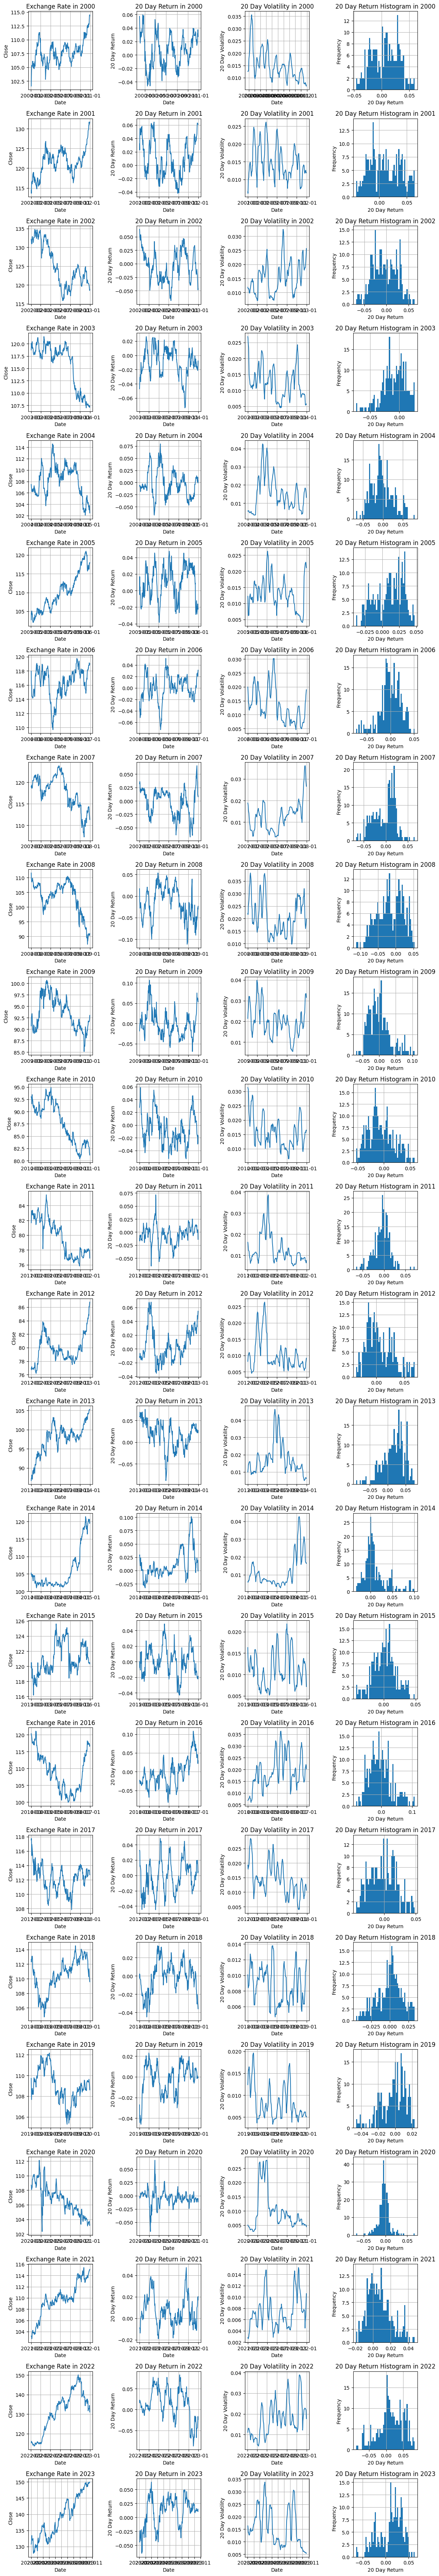

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# ディレクトリパス
dir_path = '/workspaces/GPRtest/MarketData'

# CSVファイルのパス
csv_file = os.path.join(dir_path, 'USD_JPY 過去データ_merged.csv')

# データを読み込む
df = pd.read_csv(csv_file)

# '日付け'を'Date'に変更し、datetime型に変換
df['Date'] = pd.to_datetime(df['日付け'])
df = df.drop(columns=['日付け'])
df = df.rename(columns={'終値': 'Close'})

# 日付でソートする
df = df.sort_values('Date')

# 20日間のリターンを計算する
df['20_day_return'] = df['Close'].pct_change(20)

# 20日間リターンの20日間ボラティリティを計算する
df['20_day_volatility'] = df['20_day_return'].rolling(window=20).std()

# 年ごとにデータを分割
years = df['Date'].dt.year.unique()

# 描画
fig, axs = plt.subplots(len(years), 4, figsize=(12, 3*len(years)))

for i, year in enumerate(years):
    data = df[df['Date'].dt.year == year]
    
    # 為替レートの時系列グラフ
    axs[i, 0].plot(data['Date'], data['Close'])
    axs[i, 0].set_title(f'Exchange Rate in {year}')
    axs[i, 0].set_xlabel('Date')
    axs[i, 0].set_ylabel('Close')
    axs[i, 0].grid(True)
    
    # 20日間リターンの時系列グラフ
    axs[i, 1].plot(data['Date'], data['20_day_return'])
    axs[i, 1].set_title(f'20 Day Return in {year}')
    axs[i, 1].set_xlabel('Date')
    axs[i, 1].set_ylabel('20 Day Return')
    axs[i, 1].grid(True)
    
    # ボラティリティの時系列グラフ
    axs[i, 2].plot(data['Date'], data['20_day_volatility'])
    axs[i, 2].set_title(f'20 Day Volatility in {year}')
    axs[i, 2].set_xlabel('Date')
    axs[i, 2].set_ylabel('20 Day Volatility')
    axs[i, 2].grid(True)
    
    # 20日間リターンのヒストグラム
    axs[i, 3].hist(data['20_day_return'].dropna(), bins=50)
    axs[i, 3].set_title(f'20 Day Return Histogram in {year}')
    axs[i, 3].set_xlabel('20 Day Return')
    axs[i, 3].set_ylabel('Frequency')
    axs[i, 3].grid(True)

plt.tight_layout()
plt.show()



このコードは、指定されたディレクトリからCSVファイルを読み込み、'日付け'を'Date'に変更し、その後、'Date'列をdatetime型に変換します。その後、データをソートし、20日間のリターンとそのボラティリティを計算します。その後、各年の為替レート、20日間リターン、ボラティリティの時系列グラフを描画し、最後に各年の20日間リターンのヒストグラムを描画します。また、各グラフにタイトル、縦軸、横軸のラベルを付けます。